This is the setup cell

In [1]:
import datetime
import pathlib
import time
import math

import obspy
from obspy.signal import PPSD
import scipy

#%matplotlib #Run this line if you want interactive plots
import matplotlib.pyplot as plt
import numpy as np

import sprit

ModuleNotFoundError: No module named 'sprit'

In [ ]:
dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake'
#dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake\Test12_AM.RAC84.00.2023-02-15_2132-2200.mseed'
trimDir = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake'

params = sprit.input_param(network='AM',
                            station='RAC84',
                            loc='00', 
                            channels=['EHZ', 'EHN', 'EHE'],
                            acq_date = 46, #'2023-02-15'
                            starttime = '15:31:00.00',
                            endtime = '16:00:00.00',
                            tzone = -6,#or 'local', #or 'UTC'
                            dst=False,
                            lon = -88.2290526,
                            lat =  40.1012122,
                            elevation = 755,
                            site='GEophys Test',
                            depth = 0,
                            instrument='Raspberry Shake',
                            dataPath = dPath,
                            )

No metadata file specified!
Using default metadata file for Raspberry Shake v.7 contained in repository at
 C:/Users/riley/LocalData/Github/hvsr4python/hvsr/resources/raspshake_metadata.inv


In [ ]:
params = sprit.get_metadata(params)
stream = sprit.fetch_data(params, source='raw', trim_dir=trimDir)
#stream = hvsr.trim_data(stream, params, export_format='mseed', export_dir=params['dataPath'])
ppsds = sprit.generate_ppsds(params=params, stream=stream, ppsd_length=120, overlap=0.25 )
hvsr_dict = sprit.process_hvsr(params=params, method=4, resample=True, smooth=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\riley\\LocalData\\Github\\hvsr4python\\hvsr\\resources\\raspshake_metadata.inv'

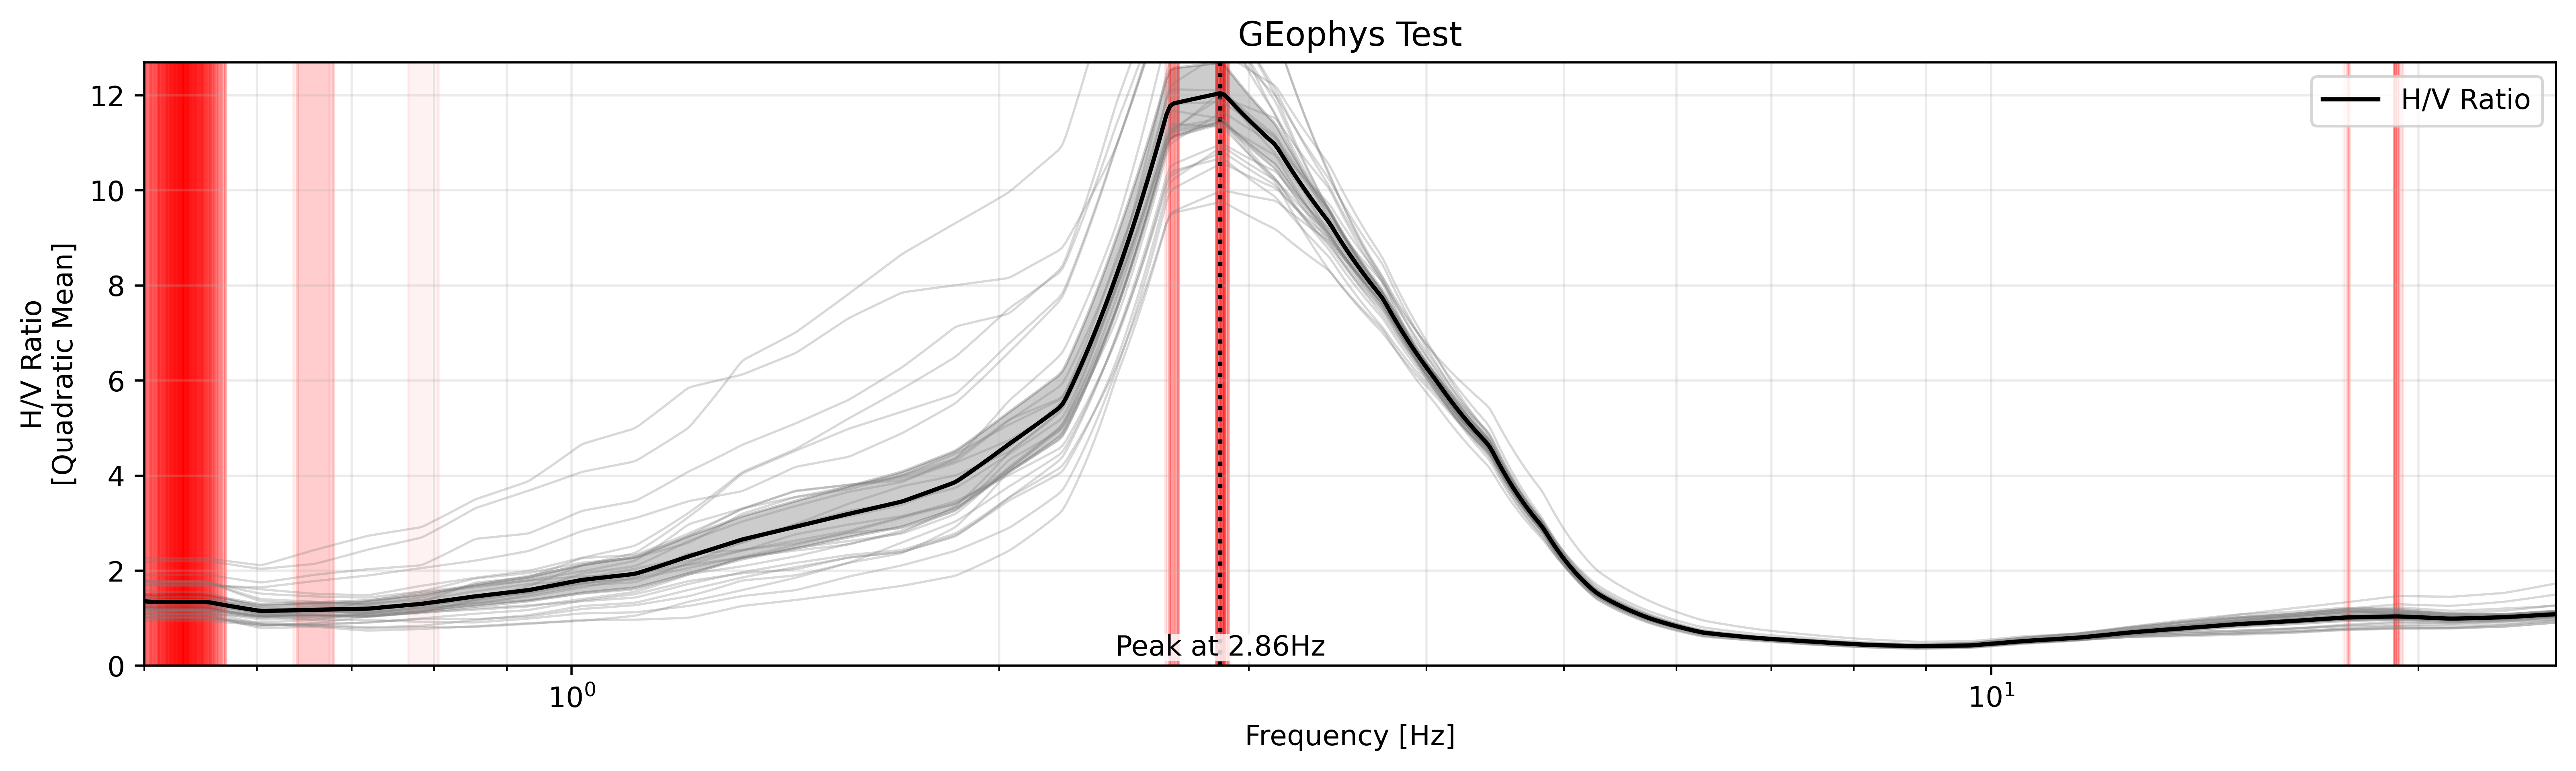

In [35]:
hvsr_dict = hvsr.check_peaks(hvsr_dict=hvsr_dict, rank=True, hvsr_band=[0.5, 25], do_rank=False)
hvsr.hvplot(hvsr_dict, kind='HVSR p tp ann', grid='both', save_dir=r'C:\Users\riley\OneDrive\Desktop', show=True)

In [9]:
import pydoc
import hvsr
import os

os.chdir(r'C:\Users\riley\LocalData\Github\hvsr4python\hvsr')

!pydoc -w hvsrtools

wrote hvsrtools.html


In [32]:
hvsr_dict['Peak Report']

[{'f0': 2.827862641850836,
  'A0': 12.09068277813693,
  'f-': '     0.711 ✔',
  'f+': '    11.311 ✔',
  'Sf': 7.111089821046475,
  'Sa': 0.12379982685807016,
  'Score': 5,
  'Report': {'A0': '     12.09 > 2.0 ✔',
   'P+': '2.793 within ±5% of 2.828 ✔',
   'P-': '2.863 within ±5% of 2.828 ✔',
   'Sf': '    7.1111 < 0.05 * 2.828  X',
   'Sa': '    0.1238 < 0.20 ✔'},
  'Pass List': {'Window Length Freq.': True,
   'Significant Cycles': True,
   'Low Curve StDev. over time': True,
   'Peak Freq. Clarity Below': True,
   'Peak Freq. Clarity Above': True,
   'Peak Amp. Clarity': True,
   'Freq. Stability': True,
   'Peak Stability (freq. std)': False,
   'Peak Stability (amp. std)': True}}]